# Galaxy sampling checks

## Imports

In [1]:
import astropy.units as u
from astropy.cosmology import WMAP9 as cosmo
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.transforms as transforms
from scipy.stats import norm
from scipy.integrate import quad

import sys
sys.path.append('..')
from src.sfh import GSMF, SFMR, MZR, Corrections
from src.sampling import GalaxyGrid
from src.utils import ZOH_to_FeH, ZOH_to_FeH2, ZOH_from_FeH, FeH_to_Z
from src.constants import LOGE, LN10, GALAXYGRID_DIR_PATH

## Definitions

In [2]:
plt.style.use('./plotstyle.mplstyle')
FIGURE_FOLDER = Path('./figures')

In [3]:
cm_cubehelix = sns.cubehelix_palette(as_cmap=True)

In [4]:
llim_feh = -2.25
ulim_feh = 0.45
llim_zoh = ZOH_from_FeH(llim_feh)
ulim_zoh = ZOH_from_FeH(ulim_feh)

In [5]:
logm_min = 6
logm_max = 12

In [6]:
highmet_MZR = 'KK04'
highmet_SFMR = 'none'
highmet_GSMF_fixedslope =  True

midmet_MZR = 'M09'
midmet_SFMR = 'moderate'
midmet_GSMF_fixedslope =  True

lowmet_MZR = 'PP04'
lowmet_SFMR = 'sharp'
lowmet_GSMF_fixedslope =  True

In [7]:
MZR_option = midmet_MZR
SFMR_option = midmet_SFMR
GSMF_option = midmet_GSMF_fixedslope
file_suffix = '_midmet'

In [8]:
def get_bin_centers(bin_edges):
    bin_centers = np.array([(x0+x1)/2 for x0, x1 in zip(bin_edges[:-1], bin_edges[1:])])
    return bin_centers

In [34]:
def get_sample(logm, redshift, flattening, fixed_slope, mzr_model, scatter_model, igimf):
    sfmr = SFMR(redshift=redshift,
                flattening=flattening,
                scatter_model=scatter_model)
    mzr = MZR(redshift=redshift,
              model=MZR_option,
              scatter_model=scatter_model)
    mzr.set_params()
    
    logsfr = sfmr.logsfr(logm)
    sfr = 10.**logsfr
    zoh = mzr.zoh(logm)
    feh = np.array([ZOH_to_FeH(x) for x in zoh])
    
    if igimf:
        corrections = Corrections(feh, np.tile(logsfr.reshape((logsfr.shape[0], 1)), (1,feh.shape[0])))
        corrections.load_data()
        try:
            corr = np.diag(corrections.get_corrections())
        except ValueError:
            corr = np.tile(np.nan, sfr.shape[0])
        sfr *= 10.**corr
    
    return sfr, zoh

In [11]:
def sfrd_dlogm(logm, redshift, flattening, fixed_slope, mzr_model, scatter_model, igimf):
    sfr, zoh = get_sample(logm, redshift, flattening, fixed_slope, mzr_model, scatter_model, igimf)
    gsmf = GSMF(redshift=redshift,
                fixed_slope=fixed_slope)
    return sfr * 10.**gsmf.log_gsmf(logm)

In [12]:
def sfrd(redshift, flattening, fixed_slope, mzr_model, scatter_model, igimf):
    gsmf = GSMF(redshift=redshift,
                fixed_slope=fixed_slope)
    def f(logm): 
        sfr, zoh = get_sample(logm, redshift, flattening, fixed_slope, mzr_model, scatter_model, igimf)
        return sfr * 10.**gsmf.log_gsmf(logm)
    sfrd = quad(f, 6., 12.)[0]
    return sfrd

# Consistency checks

### Background plot

In [44]:
model_settings = {
    'flattening': SFMR_option,
    'fixed_slope': GSMF_option,
    'mzr_model': MZR_option,
    'scatter_model': 'normal',
    'igimf': True
}

In [119]:
# PLOT SETTINGS
side = 50
bin_sample_size = 100  # size of the sample drawn within each redshift-mass bin
minz = 0
maxz = 10
min_logm = 6
max_logm = 12

bg_redshift_bins = np.linspace(minz, maxz, side+1)
bg_logm_bins = np.linspace(min_logm, max_logm, side+1)

bg_redshifts = np.array([(z0+z1)/2 for z0, z1 in zip(bg_redshift_bins[1:], bg_redshift_bins[:-1])])
bg_logms = np.array([(logm0+logm1)/2 for logm0, logm1 in zip(bg_logm_bins[1:], bg_logm_bins[:-1])])


#########
# PLOT GRID
bg_ndensity = np.zeros((side, side, bin_sample_size))
bg_sfr = np.zeros((side, side, bin_sample_size))
bg_zoh = np.zeros((side, side, bin_sample_size))

for row, (z0, z1) in enumerate(zip(bg_redshift_bins[1:], bg_redshift_bins[:-1])):
    redshift = (z0+z1) / 2
    gsmf = GSMF(redshift=redshift,
                fixed_slope=model_settings['fixed_slope'])
    for col, (logm0, logm1) in enumerate(zip(bg_logm_bins[1:], bg_logm_bins[:-1])):
        #print(row, col)
        ndensity = np.abs(quad(lambda logm: 10.**gsmf.log_gsmf(logm), logm0, logm1)[0])
        ndensity_sample = np.tile(ndensity/bin_sample_size, bin_sample_size)
        logm_sample = np.random.uniform(logm0, logm1, bin_sample_size)        
        sfr_sample, zoh_sample = get_sample(logm_sample, redshift, **model_settings)
    
        bg_ndensity[row, col] = ndensity_sample
        bg_sfr[row, col] = sfr_sample
        bg_zoh[row, col] = zoh_sample

    if not (row+1)%10:
        print(f'{row+1} out of {side} rows complete.')

C:\Users\lucas\Documents\GitHub\BOSSA\notebooks\..\src\utils.py:83: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  [FeH] = fsolve(_FeH_from_ZOH, np.array([-1]), args=ZOH)


10 out of 50 rows complete.
20 out of 50 rows complete.
30 out of 50 rows complete.
40 out of 50 rows complete.
50 out of 50 rows complete.


In [120]:
bg_redshift = np.tile(bg_redshifts.reshape((side,1)), (1, side)).reshape((side, side, 1))
bg_redshift = np.tile(bg_redshift, (1, 1, bin_sample_size))

In [121]:
bg_logm = np.tile(bg_logms, (side, 1)).reshape((side, side, 1))
bg_logm = np.tile(bg_logm, (1, 1, bin_sample_size))

In [122]:
bg_sample = np.array([bg_redshift, 
                      bg_logm,
                      bg_ndensity, 
                      np.log10(bg_sfr), 
                      bg_zoh])

In [126]:
bg_sample = bg_sample.T.reshape((side*side*bin_sample_size, 5))

So that each line is a "galaxy" with `(redshift, logm, ndensity, log(sfr), zoh)`. Now defined the bins, sum the densities and multiply by the corresponding SFR.

In [127]:
bg_min_logsfr = np.nanmin(bg_sample[:, 3])
bg_max_logsfr = np.nanmax(bg_sample[:, 3])
bg_min_zoh = np.nanmin(bg_sample[:, 4])
bg_max_zoh = np.nanmax(bg_sample[:, 4])

bg_logsfr_grid = np.linspace(bg_min_logsfr, bg_max_logsfr, side+1)
bg_zoh_grid = np.linspace(bg_min_zoh, bg_max_zoh, side+1)
bg_logsfrd_grid = np.zeros((side, side))

for row, (zoh0, zoh1) in enumerate(zip(bg_zoh_grid[:-1], bg_zoh_grid[1:])):
    zoh_sample = bg_sample[np.logical_and(bg_sample[:, 4] >= zoh0, bg_sample[:, 4] < zoh1)]
    #print(zoh0, zoh1, zoh_sample.shape)
    for col, (logsfr0, logsfr1) in enumerate(zip(bg_logsfr_grid[:-1], bg_logsfr_grid[1:])):
        sfr_sample = zoh_sample[np.logical_and(zoh_sample[:, 3] >= logsfr0, zoh_sample[:, 3] < logsfr1)]
        sfr_sample = sfr_sample[~np.isnan(sfr_sample[:,3])]
        #print(logsfr0, logsfr1, sfr_sample.shape)
        sfrd = np.sum(sfr_sample[:,2] * 10.**sfr_sample[:,3])
        bg_logsfrd_grid[row, col] = np.log10(sfrd)

C:\Users\lucas\AppData\Local\Temp\ipykernel_31600\4086427889.py:18: RuntimeWarning: divide by zero encountered in log10
  bg_logsfrd_grid[row, col] = np.log10(sfrd)


In [128]:
bg_logsfr_grid_scatter = bg_logsfr_grid
bg_zoh_grid_scatter = bg_zoh_grid
bg_logsfrd_grid_scatter = np.copy(bg_logsfrd_grid)

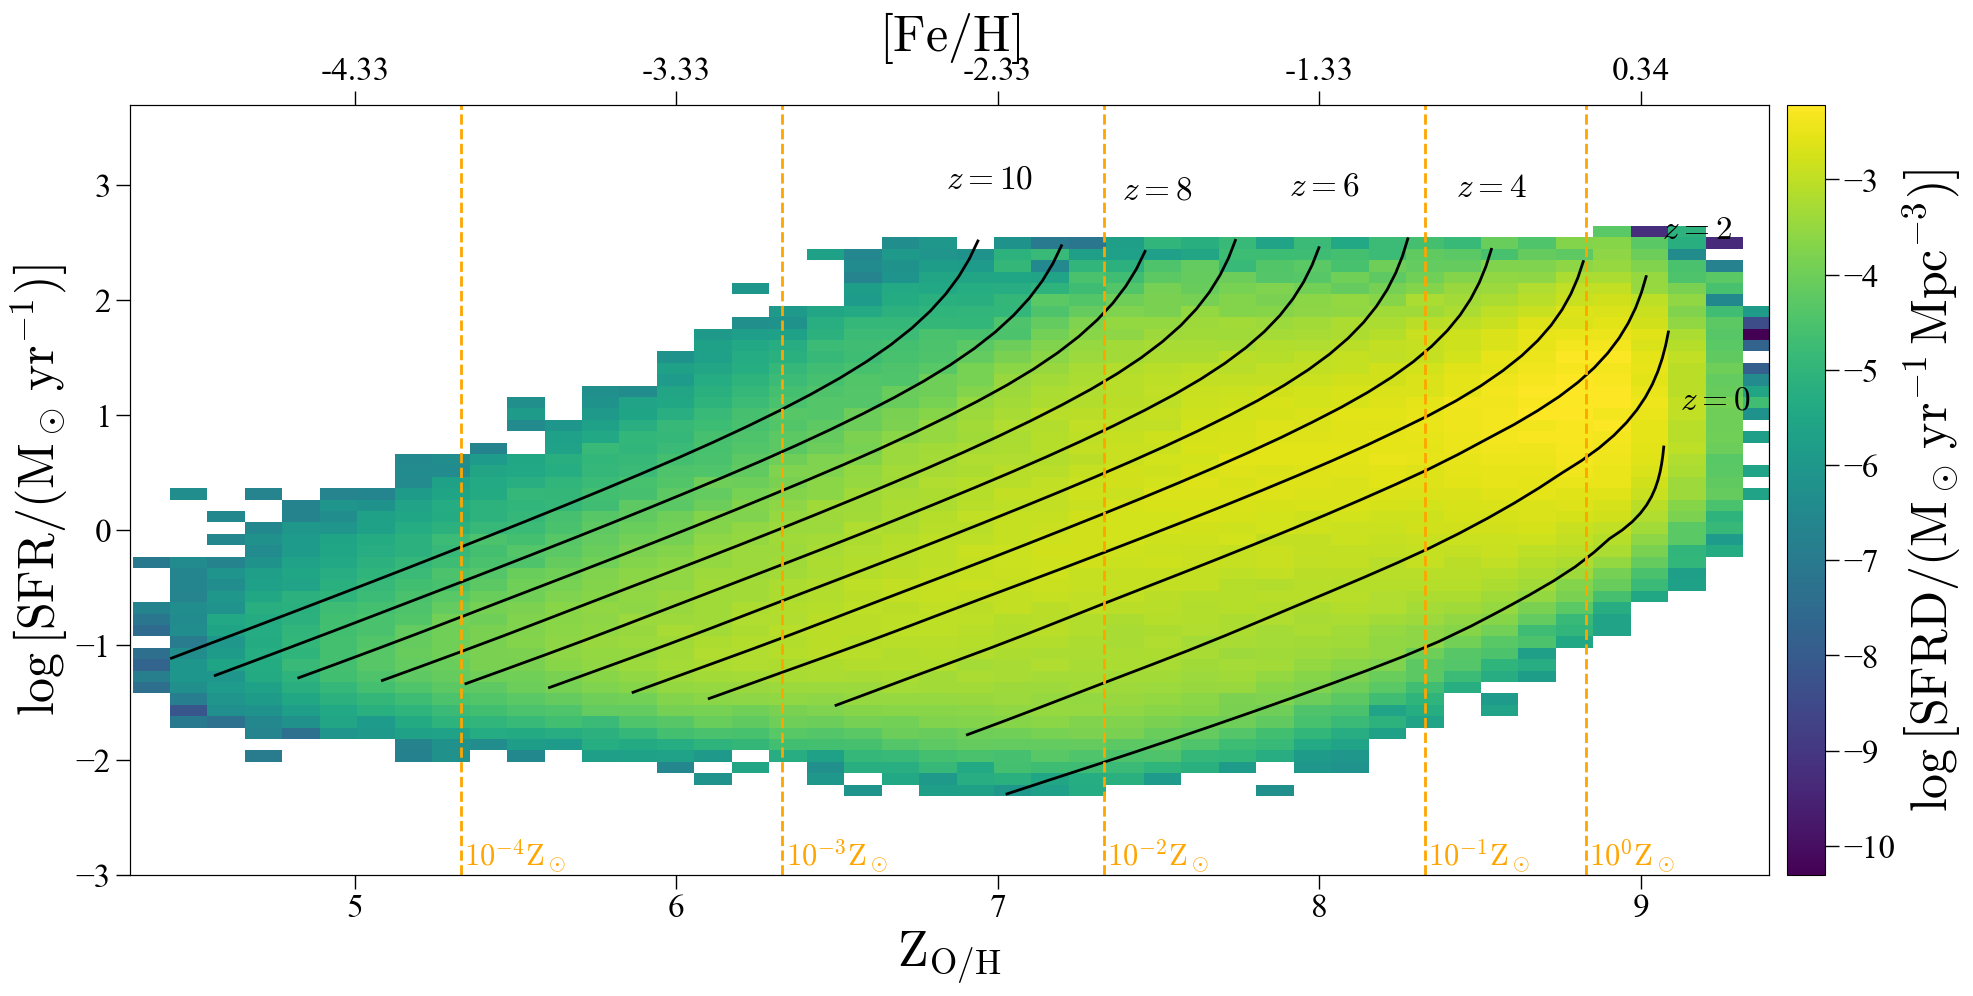

In [129]:
colormap = bg_logsfrd_grid_scatter.T
x = bg_zoh_grid_scatter
y = bg_logsfr_grid_scatter

#minx = np.floor(x.min())
minx = 4.3
#maxx = np.floor(x.max())
maxx = 9.4
#miny = np.floor(y.min())
miny = -3
#maxy = np.floor(y.max())*1.5
maxy = 3.7

fig, ax = plt.subplots(figsize=(22.5,10))#, layout='compressed')
rect = fig.patch
rect.set_facecolor('white')

vmin = colormap[colormap != -np.inf].min()
vmax = colormap[colormap != np.inf].max()

ax.pcolormesh(x, y, colormap, vmin=vmin, vmax=vmax)

# Scatterless constant redshift curves
for z, guide_plot in zip(guideline_redshifts, redshift_guide_plot):
    ax.plot(guide_plot[0], guide_plot[1], 'k-')
    if not z%2:
        posx = np.nanmax(guide_plot[0][guide_plot[0] != np.inf])
        posy = np.nanmax(guide_plot[1][guide_plot[1] != np.inf])
        if z <= 2:
            ha = 'left'
            va = 'center'
            posx += 0.05
            posy += 0.2
        else:
            ha = 'center'
            va = 'bottom'
            posy += 0.2
        ax.text(posx, posy+0.2, f'$z={z}$', fontsize=24, ha=ha, va=va)

# SFR axis
ax.set_ylim(miny, maxy)

# Z_O/H axis
ax.set_xlim(minx, maxx)
xticks = np.arange(np.ceil(minx), np.ceil(maxx), 1)
xticklabels = [f'{x:.0f}' for x in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

# [Fe/H] axis
feh_ax = ax.twiny()
feh_ax.set_xlim(ax.get_xlim())
feh_ax.set_xticks(xticks)
feh_ax_labels = [ZOH_to_FeH(x) for x in xticks]
feh_ax.set_xticklabels([f'{x:.2f}' for x in feh_ax_labels])

# Z guidelines
z_guidelines_fehs = np.arange(np.ceil(min(feh_ax_labels)), np.ceil(max(feh_ax_labels)), 1)
z_guidelines_zohs = np.array([ZOH_from_FeH(x) for x in z_guidelines_fehs])
for feh, zoh in zip(z_guidelines_fehs, z_guidelines_zohs):
    ax.vlines(zoh, miny, maxy, color='orange', linestyle='--')
    ax.text(zoh+0.01, 0, f'$10^{{{feh:.0f}}}\\mathrm{{Z}}_\\odot$', va='bottom', ha='left', color='orange',
           transform=transforms.blended_transform_factory(ax.transData, ax.transAxes), fontsize=22)


ax.set_ylabel(r'$\log\left[\mathrm{SFR}/(\mathrm{M}_\odot\,\mathrm{yr}^{-1})\right]$')
ax.set_xlabel(r'$\mathrm{Z}_\mathrm{O/H}$')
feh_ax.set_xlabel(r'$\mathrm{[Fe/H]}$')

# Colorbar
#divider = make_axes_locatable(ax)
#cax = divider.append_axes('right', size='7%', pad='2%')
sm = cm.ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), cmap='viridis')
cb = fig.colorbar(sm, ax=ax, fraction=0.05, aspect=20, pad=0.01)
cb.set_label(r'$\log\left[\mathrm{SFRD}/(\mathrm{M}_\odot\,\mathrm{yr}^{-1}\,\mathrm{Mpc}^{-3})\right]$')

# Sample plot

## IGIMF w/ scatter

This requires us to use our SFRD grid to weight the sampling of SFR-metallicity pairs.

In [143]:
zoh_options = get_bin_centers(bg_zoh_grid_scatter)
logsfr_options = get_bin_centers(bg_logsfr_grid_scatter)

In [144]:
probs = np.copy(10**bg_logsfrd_grid_scatter.ravel())

min_prob = probs[probs != -np.inf].min()
probs -= min_prob

for i, prob in enumerate(probs):
    if prob == -np.inf:
        probs[i] = 0.

probs /= probs.sum()

In [145]:
options = np.moveaxis(np.indices(bg_logsfrd_grid_scatter.shape), 0, -1)
options = options.reshape(options.shape[0]*options.shape[1], options.shape[2])

In [146]:
choice_indices = np.random.choice(options.shape[0], p=probs, size=120)
choices = options[choice_indices]
choice_zoh_i, choice_logsfr_j = choices.T
choice_zohs = zoh_options[choice_zoh_i]
choice_logsfrs = logsfr_options[choice_logsfr_j]
choices = np.array([choice_zohs, choice_logsfrs]).T

In [147]:
choice_redshifts = np.zeros(choice_zohs.shape)
for i, choice in enumerate(choices):
    zoh, logsfr = choice
    
    zoh_bin_i = np.searchsorted(bg_zoh_grid_scatter, zoh, side='right')
    zoh_bin0, zoh_bin1 = bg_zoh_grid_scatter[zoh_bin_i-1:zoh_bin_i+1]
    logsfr_bin_i = np.searchsorted(bg_logsfr_grid_scatter, logsfr, side='right')
    logsfr_bin0, logsfr_bin1 = bg_logsfr_grid_scatter[logsfr_bin_i-1:logsfr_bin_i+1]
    
    logsfr_sample = bg_sample[(bg_sample[:,3] >= logsfr_bin0) & (bg_sample[:,3] < logsfr_bin1)]
    zoh_logsfr_sample = logsfr_sample[(logsfr_sample[:,4] >= zoh_bin0) & (logsfr_sample[:,4] < zoh_bin1)]
    redshifts = zoh_logsfr_sample[:, 0]
    
    redshift_options, probs = np.unique(redshifts, return_counts=True)
    probs = np.array(probs, dtype=np.float64).flatten()
    probs /= probs.sum()
    choice_redshifts[i] = np.random.choice(redshift_options, p=probs, size=1)[0]

In [162]:
zoh, logsfr = choices[100]

zoh_bin_i = np.searchsorted(bg_zoh_grid_scatter, zoh, side='right')
zoh_bin0, zoh_bin1 = bg_zoh_grid_scatter[zoh_bin_i-1:zoh_bin_i+1]
logsfr_bin_i = np.searchsorted(bg_logsfr_grid_scatter, logsfr, side='right')
logsfr_bin0, logsfr_bin1 = bg_logsfr_grid_scatter[logsfr_bin_i-1:logsfr_bin_i+1]

logsfr_sample = bg_sample[(bg_sample[:,3] >= logsfr_bin0) & (bg_sample[:,3] < logsfr_bin1)]
zoh_logsfr_sample = logsfr_sample[(logsfr_sample[:,4] >= zoh_bin0) & (logsfr_sample[:,4] < zoh_bin1)]
redshifts = zoh_logsfr_sample[:, 0]

hist, bin_edges = np.histogram(redshifts, bins=10)
bin_cent
#redshift_options, probs = np.unique(redshifts, return_counts=True)
#plt.hist(redshifts)
#probs = np.array(probs, dtype=np.float64).flatten()
#probs /= probs.sum()
#choice_redshifts[i] = np.random.choice(redshift_options, p=probs, size=1)[0]

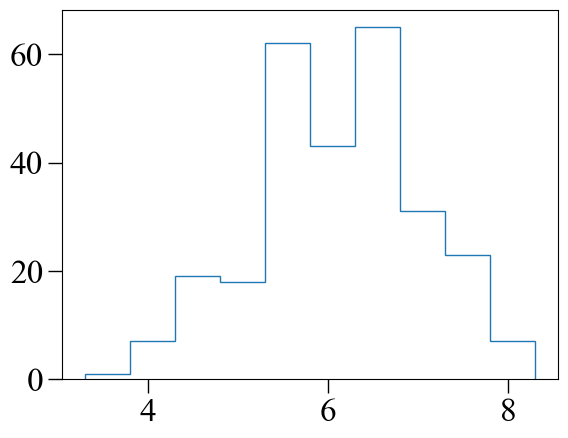

In [163]:
plt.stairs(hist, bin_edges)

In [138]:
choices = np.array([choice_zohs, choice_logsfrs, choice_redshifts]).T

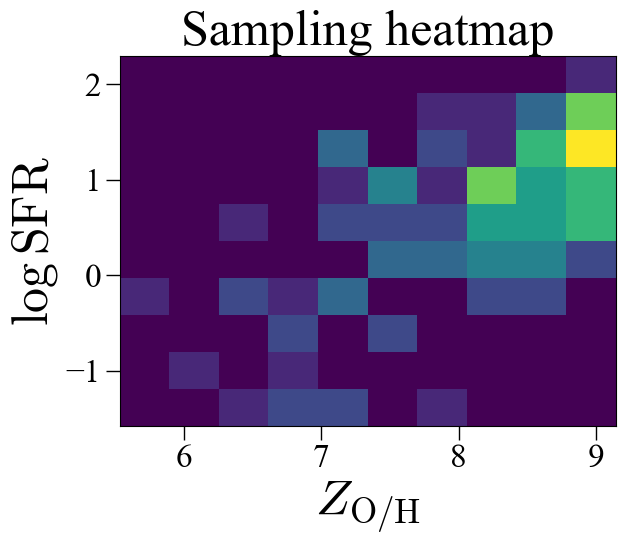

In [139]:
plt.hist2d(choice_zohs, choice_logsfrs)
plt.xlabel('$Z_\\mathrm{O/H}$')
plt.ylabel('$\\log\\mathrm{SFR}$')
plt.title('Sampling heatmap');

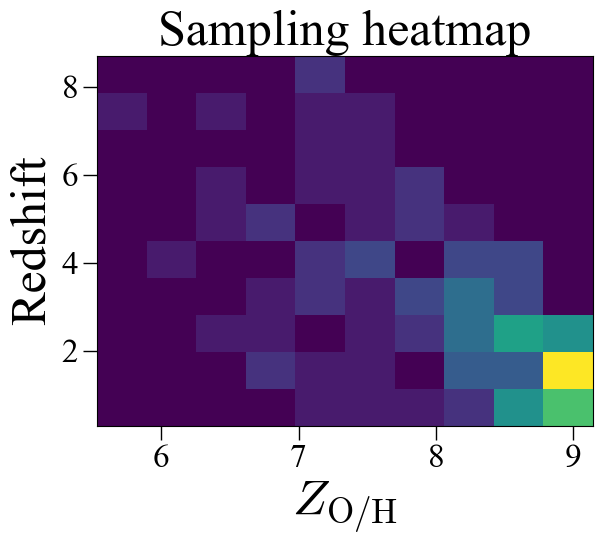

In [140]:
plt.hist2d(choice_zohs, choice_redshifts)
plt.xlabel('$Z_\\mathrm{O/H}$')
plt.ylabel('Redshift')
plt.title('Sampling heatmap');

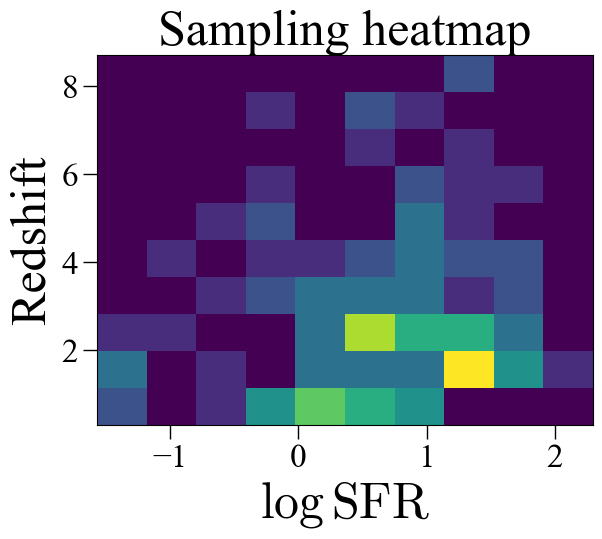

In [141]:
plt.hist2d(choice_logsfrs, choice_redshifts)
plt.xlabel('$\\log\\mathrm{SFR}$')
plt.ylabel('Redshift')
plt.title('Sampling heatmap');